# Facial Emotion Recognition

#### Table of Contents:

1. [Library Imports](#Library-Imports)
2. [Data Reading & Splitting](#Data-Reading-and-Splitting)
3. [Data Visualization](#Data-Visualization)
4. [Exploratory Data Analysis](#EDA)
5. [Data Augmentation](#Data-Augmentation)
6. [Model Metrics](#Model-Metrics)
7. [Model Training](#Model-Training)
 - [Logistic Regression Baseline](#Logistic-Regression-Baseline)
 - [Simple Neural Network Baseline](#Simple-Neural-Network-Baseline)
 - [Simple Convolutional Neural Network Baseline](#Simple-Convolutional-Neural-Network-Baseline)
 - [Convolutional Neural Network](#Convolutional-Neural-Network-Model)
 - [Transfer Learning](#Transfer-Learning)

### Library Imports

In [3]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.models import Sequential
from tensorflow.keras import regularizers as reg
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from keras import regularizers
from keras.layers import Dense, Conv2D, MaxPooling2D, ZeroPadding2D, Flatten, GlobalAveragePooling2D, InputLayer, Dropout, SpatialDropout2D, BatchNormalization, Resizing, Rescaling, RandomFlip, RandomRotation

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


### Data Reading and Splitting

In [4]:
import numpy as np
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')

# defining dir variables 
root_dir = 'Data/'
train_dir = root_dir + 'train/'
valid_dir = root_dir + 'valid/'
test_dir = root_dir + 'test/'

In [5]:
batch_size = 32
img_height = 180
img_width = 180

train_data = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size)

test_data = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size)

valid_data = tf.keras.utils.image_dataset_from_directory(
    valid_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 22962 files belonging to 7 classes.
Found 7178 files belonging to 7 classes.
Found 5747 files belonging to 7 classes.


### Data Visualization

In [6]:
class_names = train_data.class_names
num_classes = len(class_names)
print(class_names)

['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']


In [7]:
target_var = os.listdir(valid_dir)
target_var

['happy',
 '.DS_Store',
 'sad',
 'fearful',
 'neutral',
 'angry',
 'disgusted',
 'surprised']

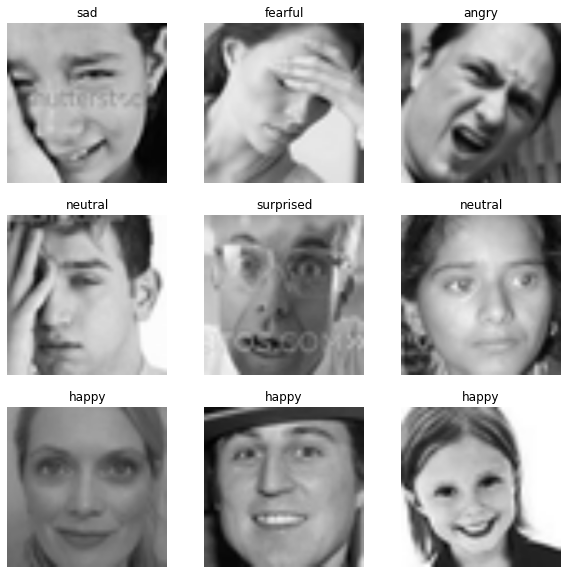

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### EDA

### Data Augmentation

- Resize the images (180x180)
- Scaling/Normalization (1 to 255)
- Randomly flip images (Horizontally)
- Randomly rotate images (up to 20°)

In [9]:
data_augmentation = Sequential([
    Resizing(48, 48),
    Rescaling(1./255),
    RandomFlip("horizontal"),
    RandomRotation(0.2)
])

### Model Metrics

In [10]:
def plot_model_performance(hist, model_name=None, save=False):
    model_hist = pd.DataFrame(hist.history)
    plt.figure(figsize=(8, 5))
    sns.lineplot(data=model_hist[['accuracy', 'val_accuracy']])
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'])
    
    if save and model_name:
        plt.title(f'{model_name} Accuracy Graph')
        plt.savefig(f'Images/{model_name} accuracy graph.png', transparent=True, bbox_inches='tight')

### Model Training

In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
test_data = test_data.cache().prefetch(buffer_size=AUTOTUNE)
valid_data = valid_data.cache().prefetch(buffer_size=AUTOTUNE)

##### Simple Neural Network Baseline

In [11]:
sbase_NN = Sequential()
sbase_NN.add(data_augmentation)
sbase_NN.add(Dense(8, activation='relu'))
sbase_NN.add(Flatten())
sbase_NN.add(Dense(7, activation='softmax'))
sbase_NN.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
sbase_NN_hist = sbase_NN.fit(train_data, epochs=4, validation_data=valid_data, verbose=1)

Epoch 1/4
718/718 [==============================] - 32s 43ms/step - loss: 1.8186 - accuracy: 0.2458 - val_loss: 1.8159 - val_accuracy: 0.1829
Epoch 2/4
 41/718 [>.............................] - ETA: 1:08 - loss: 1.8015 - accuracy: 0.2241

In [ ]:
plot_model_performance(sbase_NN_hist,'Simple Baseline NN', save=True)

In [ ]:
train_loss, train_acc = sbase_NN.evaluate(train_data, verbose=1)
valid_loss, valid_acc = sbase_NN.evaluate(valid_data, verbose=1)

print(f'\n\nTraining Accuracy:\t{train_acc * 100}\nTraining Loss:\t\t{train_loss}\n')
print(f'Validation Accuracy:\t{valid_acc * 100}\nValidation Loss:\t{valid_loss}\n')
print('Train/Validation Diff:\t', (train_acc - valid_acc) * 100)

##### Neural Network Baseline

In [10]:
base_NN = Sequential()
base_NN.add(data_augmentation)
base_NN.add(Dense(4, activation='relu'))
base_NN.add(Dense(8, activation='relu'))
base_NN.add(Dense(16,activation='relu'))
base_NN.add(Dense(32,activation='relu'))
base_NN.add(Dense(16,activation='relu'))
base_NN.add(Dense(8, activation='relu'))
base_NN.add(Flatten())
base_NN.add(Dense(7, activation='softmax'))

base_NN.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [11]:
base_NN_hist = base_NN.fit(train_data, epochs=6, validation_data=valid_data, verbose=1)

Epoch 1/6
718/718 [==============================] - 52s 71ms/step - loss: 1.7920 - accuracy: 0.2479 - val_loss: 1.7898 - val_accuracy: 0.2495
Epoch 2/6
718/718 [==============================] - 71s 100ms/step - loss: 1.7751 - accuracy: 0.2623 - val_loss: 1.7770 - val_accuracy: 0.2533
Epoch 3/6
718/718 [==============================] - 66s 91ms/step - loss: 1.7673 - accuracy: 0.2699 - val_loss: 1.7708 - val_accuracy: 0.2584
Epoch 4/6
718/718 [==============================] - 68s 95ms/step - loss: 1.7623 - accuracy: 0.2692 - val_loss: 1.7681 - val_accuracy: 0.2572
Epoch 5/6
718/718 [==============================] - 71s 98ms/step - loss: 1.7622 - accuracy: 0.2711 - val_loss: 1.7596 - val_accuracy: 0.2619
Epoch 6/6
718/718 [==============================] - 64s 90ms/step - loss: 1.7588 - accuracy: 0.2711 - val_loss: 1.7599 - val_accuracy: 0.2617


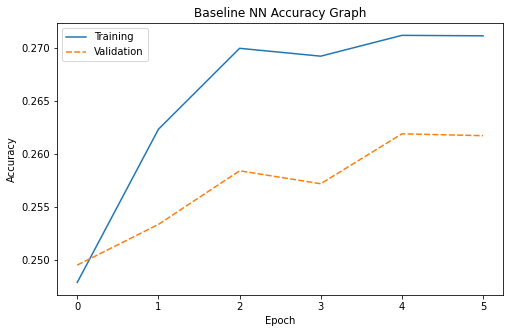

In [12]:
plot_model_performance(base_NN_hist, 'Baseline NN', save=True)

In [13]:
train_loss, train_acc = base_NN.evaluate(train_data, verbose=1)
valid_loss, valid_acc = base_NN.evaluate(valid_data, verbose=1)

print(f'\n\nTraining Accuracy:\t{train_acc * 100}\nTraining Loss:\t\t{train_loss}\n')
print(f'Validation Accuracy:\t{valid_acc * 100}\nValidation Loss:\t{valid_loss}\n')
print('Train/Validation Diff:\t', (train_acc - valid_acc) * 100)

180/180 [==============================] - 12s 64ms/step - loss: 1.7599 - accuracy: 0.2617


Training Accuracy:	26.6440212726593
Training Loss:		1.752709150314331

Validation Accuracy:	26.1701762676239
Validation Loss:	1.7598847150802612

Train/Validation Diff:	 0.4738450050354004


##### Simple Convolutional Neural Network Baseline

In [11]:
base_CNN = Sequential()
base_CNN.add(data_augmentation)
base_CNN.add(Conv2D(filters=10, kernel_size=3, activation='relu', padding='same'))
base_CNN.add(MaxPooling2D())
base_CNN.add(Conv2D(filters=5, kernel_size=3, activation='relu', padding='same'))
base_CNN.add(MaxPooling2D())
base_CNN.add(Flatten())
base_CNN.add(Dense(7, activation='softmax'))
base_CNN.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [12]:
base_CNN_hist = base_CNN.fit(train_data, epochs=5, validation_data=valid_data, verbose=1)

Epoch 1/5
718/718 [==============================] - 46s 63ms/step - loss: 1.7983 - accuracy: 0.2564 - val_loss: 1.7633 - val_accuracy: 0.2666
Epoch 2/5
718/718 [==============================] - 81s 113ms/step - loss: 1.7615 - accuracy: 0.2700 - val_loss: 1.7424 - val_accuracy: 0.2748
Epoch 3/5
718/718 [==============================] - 81s 112ms/step - loss: 1.7377 - accuracy: 0.2878 - val_loss: 1.7267 - val_accuracy: 0.2995
Epoch 4/5
718/718 [==============================] - 66s 92ms/step - loss: 1.7230 - accuracy: 0.3045 - val_loss: 1.6987 - val_accuracy: 0.3106
Epoch 5/5
718/718 [==============================] - 73s 101ms/step - loss: 1.7082 - accuracy: 0.3133 - val_loss: 1.6876 - val_accuracy: 0.3188


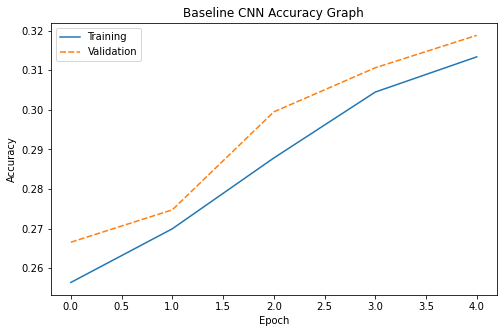

In [13]:
plot_model_performance(base_CNN_hist, 'Baseline CNN', save=True)

In [14]:
train_loss, train_acc = base_CNN.evaluate(train_data, verbose=1)
valid_loss, valid_acc = base_CNN.evaluate(valid_data, verbose=1)

print(f'\n\nTraining Accuracy:\t{train_acc * 100}\nTraining Loss:\t\t{train_loss}\n')
print(f'Validation Accuracy:\t{valid_acc * 100}\nValidation Loss:\t{valid_loss}\n')
print('Train/Validation Diff:\t', (train_acc - valid_acc) * 100)

180/180 [==============================] - 13s 72ms/step - loss: 1.6876 - accuracy: 0.3188


Training Accuracy:	33.17655324935913
Training Loss:		1.6737563610076904

Validation Accuracy:	31.87749981880188
Validation Loss:	1.6876177787780762

Train/Validation Diff:	 1.299053430557251


##### Convolutional Neural Network Model

In [14]:
sgd_opt = SGD(learning_rate=0.001) 
adam_opt = Adam(learning_rate=0.0001)

In [ ]:
CNN = Sequential()

CNN.add(data_augmentation)

CNN.add(Conv2D(filters=32, strides=2, kernel_size=3, kernel_regularizer=reg.L2(), activation='relu', padding='same'))
CNN.add(SpatialDropout2D(0.4))
CNN.add(BatchNormalization())
CNN.add(Conv2D(filters=32, strides=2, kernel_size=3, kernel_regularizer=reg.L2(), activation='relu', padding='same'))
CNN.add(SpatialDropout2D(0.4))
CNN.add(BatchNormalization())

CNN.add(Conv2D(filters=64, strides=2, kernel_size=3, kernel_regularizer=reg.L2(), activation='relu', padding='same'))
CNN.add(SpatialDropout2D(0.4))
CNN.add(BatchNormalization())
CNN.add(Conv2D(filters=64, strides=2, kernel_size=3, kernel_regularizer=reg.L2(), activation='relu', padding='same'))
CNN.add(SpatialDropout2D(0.4))
CNN.add(BatchNormalization())

CNN.add(Conv2D(filters=128, strides=2, kernel_size=3, kernel_regularizer=reg.L2(), activation='relu', padding='same'))
CNN.add(SpatialDropout2D(0.4))
CNN.add(BatchNormalization())
CNN.add(Conv2D(filters=128, strides=2, kernel_size=3, kernel_regularizer=reg.L2(), activation='relu', padding='same'))
CNN.add(SpatialDropout2D(0.4))
CNN.add(BatchNormalization())

CNN.add(Conv2D(filters=256, strides=2, kernel_size=3, kernel_regularizer=reg.L2(), activation='relu', padding='same'))
CNN.add(SpatialDropout2D(0.4))
CNN.add(BatchNormalization())

CNN.add(GlobalAveragePooling2D())

CNN.add(Dense(7, activation='softmax'))

CNN.compile(loss='sparse_categorical_crossentropy', optimizer=adam_opt, metrics=['accuracy'])

In [ ]:
CNN_hist = CNN.fit(train_data, epochs=300, validation_data=valid_data, verbose=1, callbacks=[keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=.25, patience=4, verbose=1)])

In [ ]:
plot_model_performance(CNN_hist, 'Convultional Neural Network', save=True)

In [ ]:
train_loss, train_acc = CNN.evaluate(train_data, verbose=1)
valid_loss, valid_acc = CNN.evaluate(valid_data, verbose=1)

print(f'\n\nTraining Accuracy:\t{train_acc * 100}\nTraining Loss:\t\t{train_loss}\n')
print(f'Validation Accuracy:\t{valid_acc * 100}\nValidation Loss:\t{valid_loss}\n')
print('Train/Validation Diff:\t', np.abs(train_acc - valid_acc) * 100)

In [ ]:
CNN.save('Deliverables/cnn_model.h5')

##### Transfer Learning

Using DenseNet

In [15]:
# Freeze layers
dense_net = DenseNet169(weights='imagenet', include_top=False, input_shape=None)

for layer in dense_net.layers:
    layer.trainable = False

In [16]:
CNN_dense_transfer = Sequential()
CNN_dense_transfer.add(dense_net)
CNN_dense_transfer.add(GlobalAveragePooling2D())

CNN_dense_transfer.add(Dense(256 , activation ='relu'))
CNN_dense_transfer.add(BatchNormalization())
CNN_dense_transfer.add(Dense(128 , activation ='relu'))
CNN_dense_transfer.add(BatchNormalization())

CNN_dense_transfer.add(Dense(7, activation='softmax'))

CNN_dense_transfer.compile(loss='sparse_categorical_crossentropy', optimizer=sgd_opt, metrics = ['accuracy'])
CNN_dense_transfer.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet169 (Functional)    (None, None, None, 1664)  12642880  
                                                                 
 global_average_pooling2d_1   (None, 1664)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 256)               426240    
                                                                 
 batch_normalization_2 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 batch_normalization_3 (Batc  (None, 128)             

In [ ]:
CNN_dense_transfer_hist = CNN_dense_transfer.fit(train_data, epochs=10, validation_data=valid_data, verbose=1)

Epoch 1/10
718/718 [==============================] - ETA: 0s - loss: 2.0322 - accuracy: 0.2231

In [ ]:
plot_model_performance(CNN_dense_transfer_hist, 'Convultional Neural Network with DenseNet Transfer Learning', save=True)

In [ ]:
train_loss, train_acc = CNN_dense_transfer.evaluate(train_data, verbose=1)
valid_loss, valid_acc = CNN_dense_transfer.evaluate(valid_data, verbose=1)

print(f'\n\nTraining Accuracy:\t{train_acc * 100}\nTraining Loss:\t\t{train_loss}\n')
print(f'Validation Accuracy:\t{valid_acc * 100}\nValidation Loss:\t{valid_loss}\n')
print('Train/Validation Diff:\t', np.abs(train_acc - valid_acc) * 100)

In [ ]:
pickle.dump(CNN_dense_transfer, open('model.pkl', 'wb'))

Using VGG16

In [ ]:
vgg = VGG16(weights='imagenet', include_top=False, input_shape=None)

for layer in vgg.layers:
    layer.trainable = False

In [ ]:
vgg_16_transfer = Sequential()

vgg_16_transfer.add(data_augmentation)

vgg_16_transfer.add(vgg)

vgg_16_transfer.add(GlobalAveragePooling2D()) # try it using max Pooling2

vgg_16_transfer.add(Dense(200 , activation ='relu'))
vgg_16_transfer.add(BatchNormalization())
vgg_16_transfer.add(Dense(200 , activation ='relu'))
vgg_16_transfer.add(BatchNormalization())
vgg_16_transfer.add(Dense(200 , activation ='relu'))

vgg_16_transfer.add(GlobalMaxPooling2D())
vgg_16_transfer.add(Dense(7, activation='softmax'))

vgg_16_transfer.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

In [ ]:
vgg_16_transfer = vgg_16_transfer.fit(train_data, epochs=15, validation_data=valid_data, verbose=1)

In [ ]:
plot_model_performance(vgg_16_transfer, 'Convultional Neural Network with VGG16 Transfer Learning', save=True)

In [ ]:
train_loss, train_acc = vgg_16_transfer.evaluate(train_data, verbose=1)
valid_loss, valid_acc = vgg_16_transfer.evaluate(valid_data, verbose=1)

print(f'\n\nTraining Accuracy:\t{train_acc * 100}\nTraining Loss:\t\t{train_loss}\n')
print(f'Validation Accuracy:\t{valid_acc * 100}\nValidation Loss:\t{valid_loss}\n')
print('Train/Validation Diff:\t', np.abs(train_acc - valid_acc) * 100)

In [ ]:
pickle.dump(vgg_16_transfer, open('vgg_16_transfer.pkl', 'wb'))

Using VGG19

In [12]:
vgg_19 = VGG19(weights='imagenet', include_top=False, input_shape=None)

for layer in vgg_19.layers[:-2]:
    layer.trainable = False

73703424/80134624 [==========================>...] - ETA: 2s

OSError: [Errno 28] No space left on device

In [2]:
vgg_19_transfer = Sequential()
vgg_19_transfer.add(Dropout(0.2)) # dropout
vgg_19_transfer.add(data_augmentation)

vgg_19_transfer.add(vgg_19)

vgg_19_transfer.add(GlobalAveragePooling2D())

vgg_19_transfer.add(Dense(200 , activation ='relu', kernel_regularizer=regularizers.l2(0.01))) # , kernel_regularizer=regularizers.l2(0.01)
vgg_19_transfer.add(BatchNormalization()) 
vgg_19_transfer.add(Dense(100 , activation ='relu'))

vgg_19_transfer.add(BatchNormalization())
vgg_19_transfer.add(Dense(50 , activation ='relu'))
vgg_19_transfer.add(BatchNormalization())
vgg_19_transfer.add(Dense(7, activation='softmax'))

vgg_19_transfer.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

NameError: name 'Sequential' is not defined

In [ ]:
vgg_19_transfer_hist = vgg_19_transfer.fit(train_data, epochs=10, validation_data=valid_data, verbose=1,callbacks=[
        keras.callbacks.EarlyStopping(patience=8, verbose=1, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(factor=.5, patience=3, verbose=1),
    ])

'''
,callbacks=[
        keras.callbacks.EarlyStopping(patience=8, verbose=1, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(factor=.5, patience=3, verbose=1),
    ]
'''

In [ ]:
plot_model_performance(vgg_19_transfer_hist, 'Convultional Neural Network with VGG19 Transfer Learning', save=True)

In [ ]:
train_loss, train_acc = vgg_19_transfer.evaluate(train_data, verbose=1)
valid_loss, valid_acc = vgg_19_transfer.evaluate(valid_data, verbose=1)

print(f'\n\nTraining Accuracy:\t{train_acc * 100}\nTraining Loss:\t\t{train_loss}\n')
print(f'Validation Accuracy:\t{valid_acc * 100}\nValidation Loss:\t{valid_loss}\n')
print('Train/Validation Diff:\t', np.abs(train_acc - valid_acc) * 100)

In [ ]:
pickle.dump(vgg_19_transfer, open('vgg_19_transfer.pkl', 'wb'))

Using InceptionV3

In [ ]:
inception_v3 = InceptionV3(weights='imagenet', include_top=False, input_shape=None)

for layer in inception_v3.layers[:-1]:
    layer.trainable = False

In [ ]:
inception_transfer = Sequential()

vgg_19_transfer.add(Dropout(0.2)) # dropout

inception_transfer.add(data_augmentation)
inception_transfer.add(inception_v3)
inception_transfer.add(GlobalAveragePooling2D())

inception_transfer.add(Dense(200 , activation ='relu'))
inception_transfer.add(BatchNormalization())
inception_transfer.add(Dense(100 , activation ='relu'))
inception_transfer.add(BatchNormalization())
inception_transfer.add(Dense(50 , activation ='relu'))
inception_transfer.add(BatchNormalization())

inception_transfer.add(Dense(7 , activation='softmax'))

inception_transfer.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.01), metrics = ['accuracy'])

In [ ]:
inception_transfer_hist = inception_transfer.fit(train_data, epochs=15, validation_data=valid_data, verbose=1)

In [ ]:
plot_model_performance(inception_transfer_hist, 'Convultional Neural Network with InceptionV3 Transfer Learning', save=True)

In [ ]:
train_loss, train_acc = inception_transfer.evaluate(train_data, verbose=1)
valid_loss, valid_acc = inception_transfer.evaluate(valid_data, verbose=1)

print(f'\n\nTraining Accuracy:\t{train_acc * 100}\nTraining Loss:\t\t{train_loss}\n')
print(f'Validation Accuracy:\t{valid_acc * 100}\nValidation Loss:\t{valid_loss}\n')
print('Train/Validation Diff:\t', np.abs(train_acc - valid_acc) * 100)

In [ ]:
pickle.dump(inception_transfer, open('inception_transfer.pkl', 'wb'))

Using ResNet50

In [ ]:
resnet_50 = ResNet50(weights='imagenet', include_top=False, input_shape=None)

for layer in resnet_50.layers[:-1]:
    layer.trainable = False

In [ ]:
resnet_transfer = Sequential()

resnet_transfer.add(data_augmentation)

resnet_transfer.add(resnet_50)

resnet_transfer.add(GlobalAveragePooling2D())

resnet_transfer.add(Dense(200 , activation ='relu'))
resnet_transfer.add(BatchNormalization())
resnet_transfer.add(Dense(100 , activation ='relu'))
resnet_transfer.add(BatchNormalization())
resnet_transfer.add(Dense(100 , activation ='relu'))
resnet_transfer.add(BatchNormalization())

resnet_transfer.add(Dense(7 , activation='softmax'))

resnet_transfer.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

In [ ]:
resnet_transfer_hist = resnet_transfer.fit(train_data, epochs=15, validation_data=valid_data, verbose=1)

In [ ]:
plot_model_performance(resnet_transfer_hist, 'Convultional Neural Network with ResNet50 Transfer Learning', save=True)

In [ ]:
train_loss, train_acc = resnet_transfer.evaluate(train_data, verbose=1)
valid_loss, valid_acc = resnet_transfer.evaluate(valid_data, verbose=1)

print(f'\n\nTraining Accuracy:\t{train_acc * 100}\nTraining Loss:\t\t{train_loss}\n')
print(f'Validation Accuracy:\t{valid_acc * 100}\nValidation Loss:\t{valid_loss}\n')
print('Train/Validation Diff:\t', np.abs(train_acc - valid_acc) * 100)

In [ ]:
pickle.dump(resnet_transfer, open('resnet_transfer.pkl', 'wb'))

##### Chosen Model

From all the models that were testted above, the best model in terms of highest accuracy and least loss and overfit, is the `VGG19` transfer learning model